# ECE 697AM - Project 4

# Name: ______Sushma Suresh Babu__________
## Concrete Crack Dataset

This dataset is from https://www.kaggle.com/arunrk7/surface-crack-detection

**Please download the dataset from Kaggle to the datasets/concrete_crack/ folder before running this notebook.**

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle1

In [ ]:
!cp kaggle-2.json ~/.kaggle1/

cp: cannot stat 'kaggle-2.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [1]:
import os
import cv2
import csv
import numpy as np
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical

import pandas as pd

The following variable will store information about models and their performance. This information will be printed in Part 4 of the project. **ONLY RUN THIS CELL WHEN YOU FIRST START THIS NOTEBOOK** or when you want to clear the information about all the models.

In [2]:
model_performance = []

The following functions record and print model information. The use of `record_model_performance` is shown in Part 0-1. The use of `print_model_performance` is shown in Part 4.

In [3]:
def record_model_performance(name, description, input_size, parameter_count, accuracy):
    global model_performance
    model_performance = model_performance + [[name, description, input_size, parameter_count, accuracy]]

def plot_model_performance():
    name = []
    params = []
    accuracy = []
    for i in range(len(model_performance)):
        name = name + [str(model_performance[i][0])+" "+str(model_performance[i][2])]
        params = params + [model_performance[i][3]]
        accuracy = accuracy + [model_performance[i][4]]
    fig, ax = plt.subplots(figsize=(15,10))
    plt.ylim(0.9,1.01)
    ax.scatter(params, accuracy)
    ax.set_xlabel('number of parameters')
    ax.set_ylabel('accuracy')
    for i, txt in enumerate(name):
        ax.annotate(txt, (params[i], accuracy[i]+np.random.randint(1,10)/4000.-0.00125))

    
def print_model_performance():
    print('{0:10s} {1:20s} {2:>12s} {3:>16s} {4:>9s}'.format("name", "description", "input size", 
                                                              "parameter count", "accuracy"))
    for i in range(len(model_performance)):
          print('{0:10s} {1:20s} {2:>12d} {3:>16d} {4:>9.5f}'.format(model_performance[i][0], 
                                                                      model_performance[i][1], 
                                                                      model_performance[i][2], 
                                                                      model_performance[i][3], 
                                                                      model_performance[i][4]))
    
    plot_model_performance()

The following parameters can be used as a global setting for the size of the input image (up to 227). Feel free to use this paramter when constructing your CNN below so you don't have to change the code every time you change with input image size. Note that large values require more memory and smaller values reduce the quality of the input images.

As noted in Part 4, **you are required to run your models with at least two different values for the size parameter**. When you do the second run, you can simply change this parameter here and rerun your notebook. Start with the largest value of `size` that you want to try to see if the notebook crashes because it runs out of memory. (If you increase the value later and crash, then the earlier results are lost. If you decrease the `size` value, you do not need more memory than previously.) If you don't reset the `model_performance` variable above, then results from both runs will be retained.

In [4]:
size = 64 #32 

## Part 0-1: Loading of Dataset

The following code loads the data and shows the construction of a simple ANN (not CNN).

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
ls

datasets/  pProject_04.ipynb  Project_03.ipynb  Project_04.ipynb


In [7]:
cd drive/MyDrive/697am/

/content/drive/.shortcut-targets-by-id/16YhIEu9BtxhXy66Ik1n_ULVMHD54mIbj/697am


In [13]:
base_path='datasets/p_4/'

def load_images(path, size):
    images = os.listdir(path)
    images_array = np.array(images)
    imageslist = []
    for i in range(len(images_array)):
        im = img_to_array(load_img(path+images_array[i],target_size=(size,size))) / 255.
        imageslist.append(im)
    return imageslist    

crack_images = load_images(base_path + 'Positive/', size)
non_crack_images = load_images(base_path + 'Negative/', size)
images = np.array(crack_images + non_crack_images)

#labels = np.full(len(crack_images), (1,0))
#labels =np.append(labels, np.full(len(non_crack_images), (0,1)))
crack_labels = np.tile((1, 0),(len(crack_images),1))
non_crack_labels = np.tile((0, 1),(len(non_crack_images),1))
labels = np.append(crack_labels, non_crack_labels, axis=0)

In [14]:
images.shape

(40110, 64, 64, 3)

In [15]:
labels.shape

(40110, 2)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

In [17]:
X_train.shape

(32088, 64, 64, 3)

In [18]:
y_train.shape

(32088, 2)

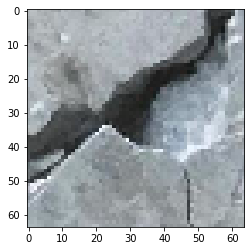

In [19]:
plt.imshow(cv2.cvtColor(X_train[199], cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
y_train[0]

array([0, 1])

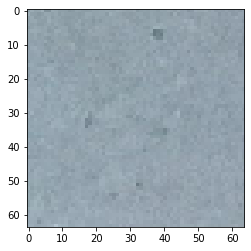

In [21]:
plt.imshow(cv2.cvtColor(X_train[4], cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
y_train[4]

array([0, 1])

## Part 0-2: Example ANN

The following code constructs and trains the neural networks. You may use any number of epochs of training. Make sure to train long enough to reach close to "steady state." In my experiments, 10-20 epochs have worked well. 

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(size, size, 3)),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=2, activation='sigmoid'),
])

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model.evaluate(X_test, y_test)

Epoch 1/20
1805/1805 [==============================] - 8s 3ms/step - loss: 0.6984 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 2/20
1805/1805 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 3/20
1805/1805 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 4/20
1805/1805 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 5/20
1805/1805 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 6/20
1805/1805 [==============================] - 5s 3ms/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6934 - val_accuracy: 0.4980
Epoch 7/20
1805/1805 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy:

The following code prints the accuracy of the model and the number of parameters in the model.

In [24]:
record_model_performance(name="default", 
                         description="ANN from Part 0-2", 
                         input_size=size, 
                         parameter_count=model.count_params(), 
                         accuracy=acc)

The following code dislays up to 10 images that were classified incorrectly. ([1 0] indicates that the image is labeled having a crack, but was classified as not having a crack. [0 1] indicates the opposite.)

4058 errors:
[0 1]


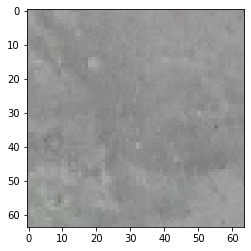

[0 1]


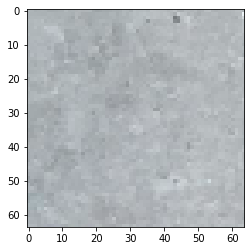

[0 1]


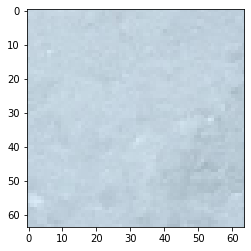

[0 1]


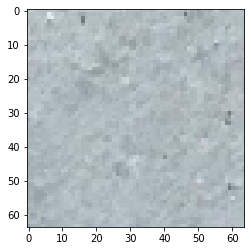

[0 1]


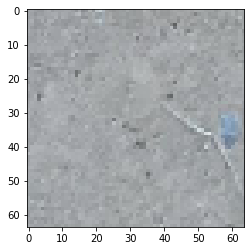

[0 1]


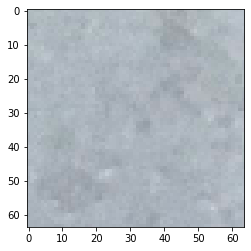

[0 1]


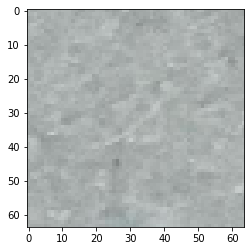

[0 1]


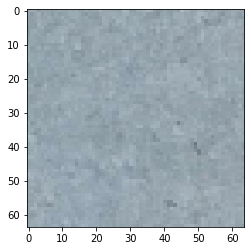

[0 1]


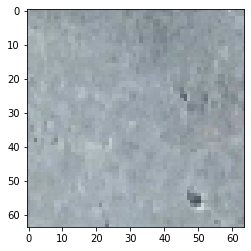

[0 1]


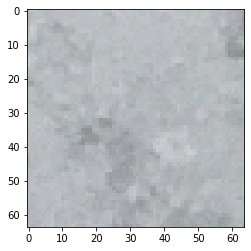

In [25]:
y_pred = model.predict(X_test)
misclassified_samples = X_test[(y_test != np.rint(y_pred).astype(int))[:,0]]
misclassified_labels = y_test[(y_test != np.rint(y_pred).astype(int))[:,0]]

print(str(len(misclassified_samples)) + " errors:")

for i in range(min(len(misclassified_samples),10)):
    print(misclassified_labels[i])
    plt.imshow(cv2.cvtColor(misclassified_samples[i], cv2.COLOR_BGR2RGB))
    plt.show()

## Part 1: Custom CNN
Construct and train a CNN from scratch (i.e., without using transfer learning).

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'),
    keras.layers.Conv2D(filters=24,kernel_size=(3,3),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=2, activation='sigmoid'),
])

model2.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model2.evaluate(X_test, y_test)

Epoch 1/20
1805/1805 [==============================] - 19s 6ms/step - loss: 0.2566 - accuracy: 0.8894 - val_loss: 0.0636 - val_accuracy: 0.9807
Epoch 2/20
1805/1805 [==============================] - 10s 6ms/step - loss: 0.0533 - accuracy: 0.9858 - val_loss: 0.0393 - val_accuracy: 0.9903
Epoch 3/20
1805/1805 [==============================] - 10s 6ms/step - loss: 0.0369 - accuracy: 0.9895 - val_loss: 0.0279 - val_accuracy: 0.9922
Epoch 4/20
1805/1805 [==============================] - 10s 6ms/step - loss: 0.4240 - accuracy: 0.7226 - val_loss: 0.6963 - val_accuracy: 0.5020
Epoch 5/20
1805/1805 [==============================] - 10s 6ms/step - loss: 0.1788 - accuracy: 0.9091 - val_loss: 0.0369 - val_accuracy: 0.9900
Epoch 6/20
1805/1805 [==============================] - 10s 6ms/step - loss: 0.0354 - accuracy: 0.9902 - val_loss: 0.0334 - val_accuracy: 0.9907
Epoch 7/20
1805/1805 [==============================] - 10s 6ms/step - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.0305 - val_ac

In [27]:
record_model_performance(name="CNN", 
                         description="CNN from Part 0-1", 
                         input_size=size, 
                         parameter_count=model2.count_params(), 
                         accuracy=acc)

41 errors:
[1 0]


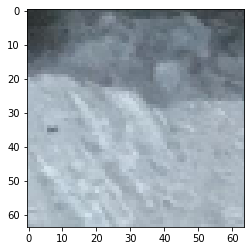

[0 1]


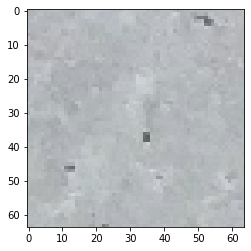

[0 1]


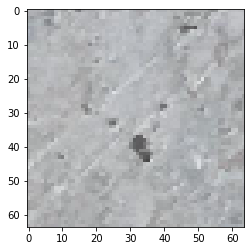

[0 1]


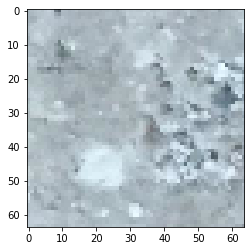

[0 1]


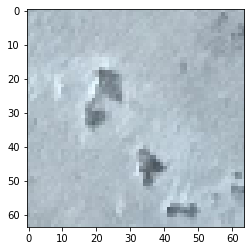

[1 0]


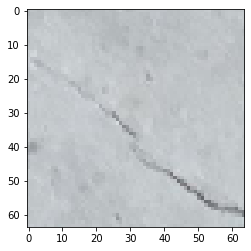

[1 0]


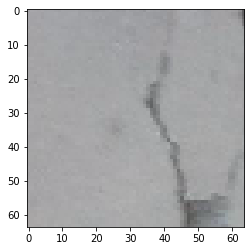

[1 0]


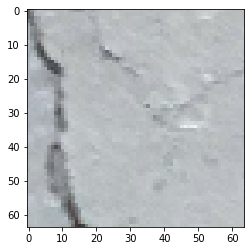

[1 0]


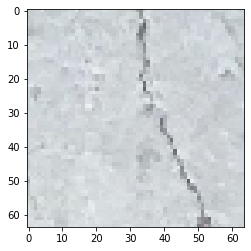

[0 1]


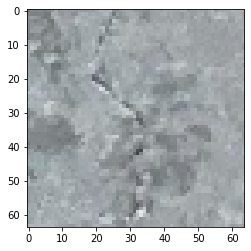

In [28]:
y_pred = model2.predict(X_test)
misclassified_samples = X_test[(y_test != np.rint(y_pred).astype(int))[:,0]]
misclassified_labels = y_test[(y_test != np.rint(y_pred).astype(int))[:,0]]

print(str(len(misclassified_samples)) + " errors:")

for i in range(min(len(misclassified_samples),10)):
    print(misclassified_labels[i])
    plt.imshow(cv2.cvtColor(misclassified_samples[i], cv2.COLOR_BGR2RGB))
    plt.show()

## Part 2: CNN with Transfer Learning
Pick a pretrained image classification network from https://keras.io/api/applications/ and use it for transfer learning. Construct and train a CNN that is based on transfer learning.

### First CNN with Transfer Learning

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [30]:
IMG_SHAPE = (size,size) + (3,)
IMG_SHAPE

(64, 64, 3)

In [31]:
# Create the base model from the pre-trained model MobileNet V2

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [35]:
prediction_layer =keras.models.Sequential([
    keras.layers.Conv2D(filters=16,kernel_size=(2,2),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(1, 1),strides=(1, 1), padding='valid'),
    keras.layers.Conv2D(filters=24,kernel_size=(2,3),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=2, activation='sigmoid'),
])



In [36]:
inputs = tf.keras.Input(shape=(size, size, 3))
x = preprocess_input(inputs)
x = base_model(x, training=True)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

In [37]:

model3.compile(optimizer="sgd",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model3.evaluate(X_test, y_test)

Epoch 1/20
1805/1805 [==============================] - 28s 14ms/step - loss: 0.0925 - accuracy: 0.9688 - val_loss: 0.0472 - val_accuracy: 0.9875
Epoch 2/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0491 - accuracy: 0.9850 - val_loss: 0.0361 - val_accuracy: 0.9903
Epoch 3/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.0365 - val_accuracy: 0.9900
Epoch 4/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.0327 - val_accuracy: 0.9941
Epoch 5/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0314 - accuracy: 0.9908 - val_loss: 0.0286 - val_accuracy: 0.9919
Epoch 6/20
1805/1805 [==============================] - 22s 12ms/step - loss: 0.0275 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9907
Epoch 7/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.0389 -

In [38]:
record_model_performance(name="CNN-TL", 
                         description="CNN from Part 2", 
                         input_size=size, 
                         parameter_count=model3.count_params(), 
                         accuracy=acc)

47 errors:
[0 1]


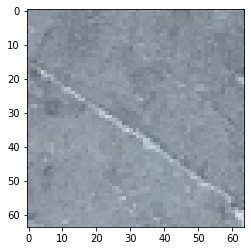

[1 0]


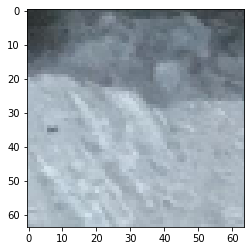

[0 1]


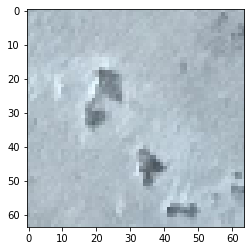

[1 0]


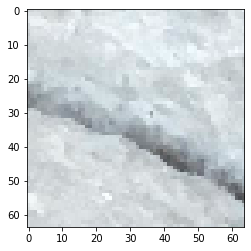

[1 0]


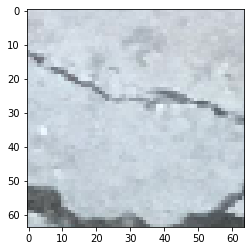

[1 0]


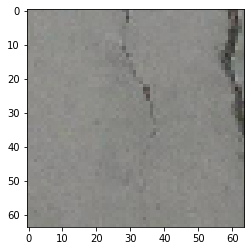

[1 0]


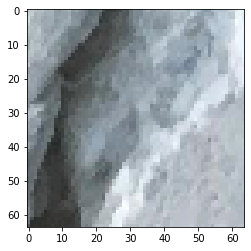

[1 0]


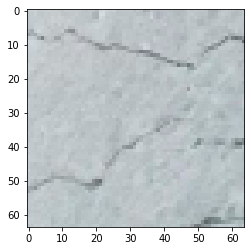

[1 0]


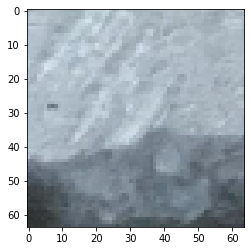

[1 0]


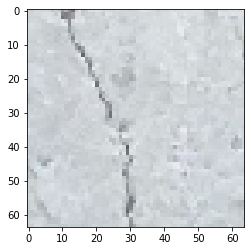

In [39]:
y_pred = model3.predict(X_test)
misclassified_samples = X_test[(y_test != np.rint(y_pred).astype(int))[:,0]]
misclassified_labels = y_test[(y_test != np.rint(y_pred).astype(int))[:,0]]

print(str(len(misclassified_samples)) + " errors:")

for i in range(min(len(misclassified_samples),10)):
    print(misclassified_labels[i])
    plt.imshow(cv2.cvtColor(misclassified_samples[i], cv2.COLOR_BGR2RGB))
    plt.show()

### Second CNN with Transfer Learning

In [42]:

base_model2 = tf.keras.applications.EfficientNetB0( include_top=False,
    input_shape = IMG_SHAPE,
    weights = 'imagenet'
    )

16719872/16705208 [==============================] - 1s 0us/step


In [43]:
base_model2.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  237


In [45]:
prediction_layer =keras.models.Sequential([
    keras.layers.Conv2D(filters=16,kernel_size=(2,2),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(1, 1),strides=(1, 1), padding='valid'),
    keras.layers.Conv2D(filters=24,kernel_size=(2,3),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=2, activation='sigmoid'),
])



In [46]:
inputs = tf.keras.Input(shape=(size, size, 3))
x = preprocess_input(inputs)
x = base_model2(x, training=True)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model4 = tf.keras.Model(inputs, outputs)

In [47]:
model4.compile(optimizer="sgd",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model3.evaluate(X_test, y_test)

Epoch 1/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0265 - val_accuracy: 0.9935
Epoch 2/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0192 - val_accuracy: 0.9956
Epoch 3/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0133 - accuracy: 0.9954 - val_loss: 0.0228 - val_accuracy: 0.9935
Epoch 4/20
1805/1805 [==============================] - 22s 12ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.0223 - val_accuracy: 0.9944
Epoch 5/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0196 - val_accuracy: 0.9935
Epoch 6/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0213 - val_accuracy: 0.9935
Epoch 7/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0219 -

In [48]:
record_model_performance(name="CNN-TL-2", 
                         description="CNN2 from Part 2", 
                         input_size=size, 
                         parameter_count=model4.count_params(), 
                         accuracy=acc)

4072 errors:
[0 1]


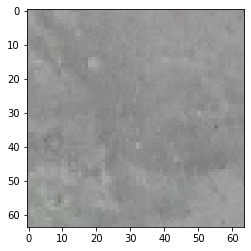

[0 1]


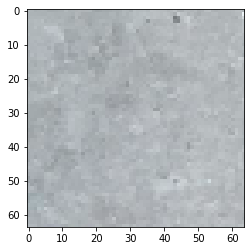

[0 1]


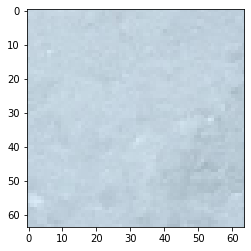

[0 1]


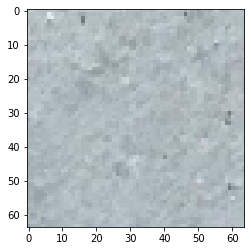

[0 1]


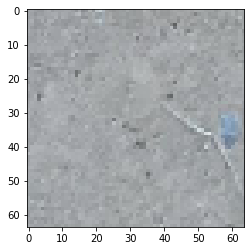

[0 1]


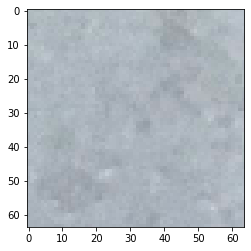

[0 1]


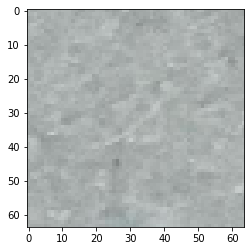

[0 1]


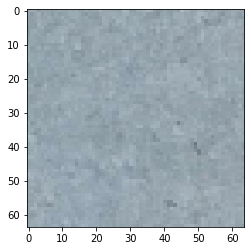

[0 1]


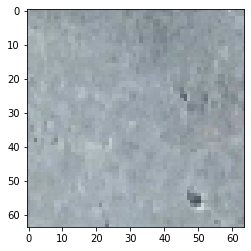

[0 1]


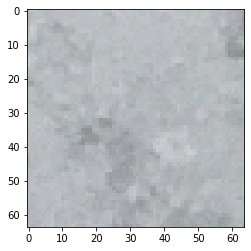

In [49]:
y_pred = model4.predict(X_test)
misclassified_samples = X_test[(y_test != np.rint(y_pred).astype(int))[:,0]]
misclassified_labels = y_test[(y_test != np.rint(y_pred).astype(int))[:,0]]

print(str(len(misclassified_samples)) + " errors:")

for i in range(min(len(misclassified_samples),10)):
    print(misclassified_labels[i])
    plt.imshow(cv2.cvtColor(misclassified_samples[i], cv2.COLOR_BGR2RGB))
    plt.show()

## Part 3: Minimal Model

In this part, find the smallest possible model (in terms of number parameters) that achieves at least 99.5% accuracy on the test set.

In [51]:
base_model3 = tf.keras.applications.EfficientNetB0( include_top=False,
    input_shape = IMG_SHAPE,
    weights = 'imagenet'
    )

In [52]:
base_model3.trainable = True

In [53]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model3.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model3.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  237


In [54]:
prediction_layer =keras.models.Sequential([
    keras.layers.Conv2D(filters=16,kernel_size=(2,2),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(1, 1),strides=(1, 1), padding='valid'),
    keras.layers.Conv2D(filters=24,kernel_size=(2,3),padding="same", activation="relu"),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=2, activation='sigmoid'),
])


In [55]:
inputs = tf.keras.Input(shape=(size, size, 3))
x = preprocess_input(inputs)
x = base_model3(x, training=True)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model5 = tf.keras.Model(inputs, outputs)

In [56]:
model5.compile(optimizer="sgd",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model3.evaluate(X_test, y_test)

Epoch 1/20
1805/1805 [==============================] - 24s 13ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0182 - val_accuracy: 0.9959
Epoch 2/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0104 - accuracy: 0.9962 - val_loss: 0.0158 - val_accuracy: 0.9956
Epoch 3/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0219 - val_accuracy: 0.9950
Epoch 4/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0212 - val_accuracy: 0.9950
Epoch 5/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0163 - val_accuracy: 0.9947
Epoch 6/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.0203 - val_accuracy: 0.9950
Epoch 7/20
1805/1805 [==============================] - 23s 13ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.0221 -

In [57]:
record_model_performance(name="minimal", 
                         description="CNN2 from Part 2", 
                         input_size=size, 
                         parameter_count=model5.count_params(), 
                         accuracy=acc)

3970 errors:
[1 0]


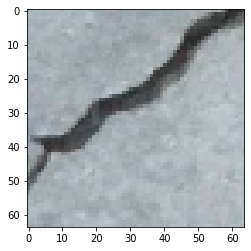

[0 1]


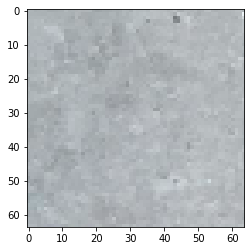

[0 1]


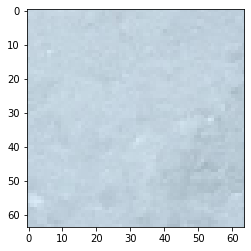

[0 1]


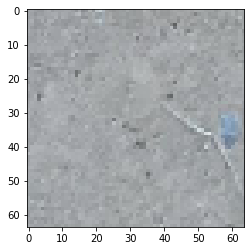

[0 1]


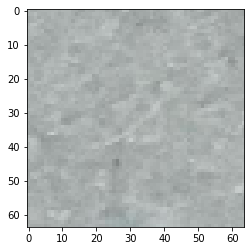

[0 1]


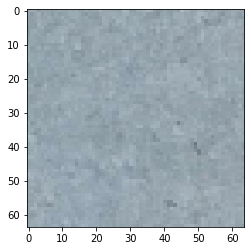

[1 0]


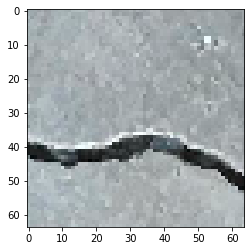

[1 0]


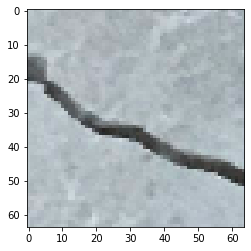

[1 0]


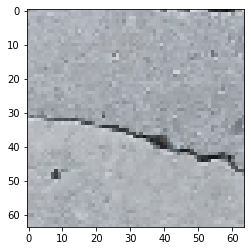

[1 0]


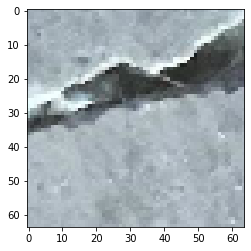

In [58]:
y_pred = model5.predict(X_test)
misclassified_samples = X_test[(y_test != np.rint(y_pred).astype(int))[:,0]]
misclassified_labels = y_test[(y_test != np.rint(y_pred).astype(int))[:,0]]

print(str(len(misclassified_samples)) + " errors:")

for i in range(min(len(misclassified_samples),10)):
    print(misclassified_labels[i])
    plt.imshow(cv2.cvtColor(misclassified_samples[i], cv2.COLOR_BGR2RGB))
    plt.show()

## Part 4: Summary

Please summarize the results from your experiments in the following table. In the end, your table should have **at least eight entries** (one ANN, on custom CNN, two CNNs with transfer learning) * 2 `size` values. You are welcome to try out and report the results of more `size` values and more CNN architecture.

name       description            input size  parameter count  accuracy
default    ANN from Part 0-2              64          1589762   0.49414
CNN        CNN from Part 0-1              64         11829594   0.99514
CNN-TL     CNN from Part 2                64          2371434   0.99427
CNN-TL-2   CNN2 from Part 2               64          4163021   0.99414
minimal    CNN2 from Part 2               64          4163021   0.99439


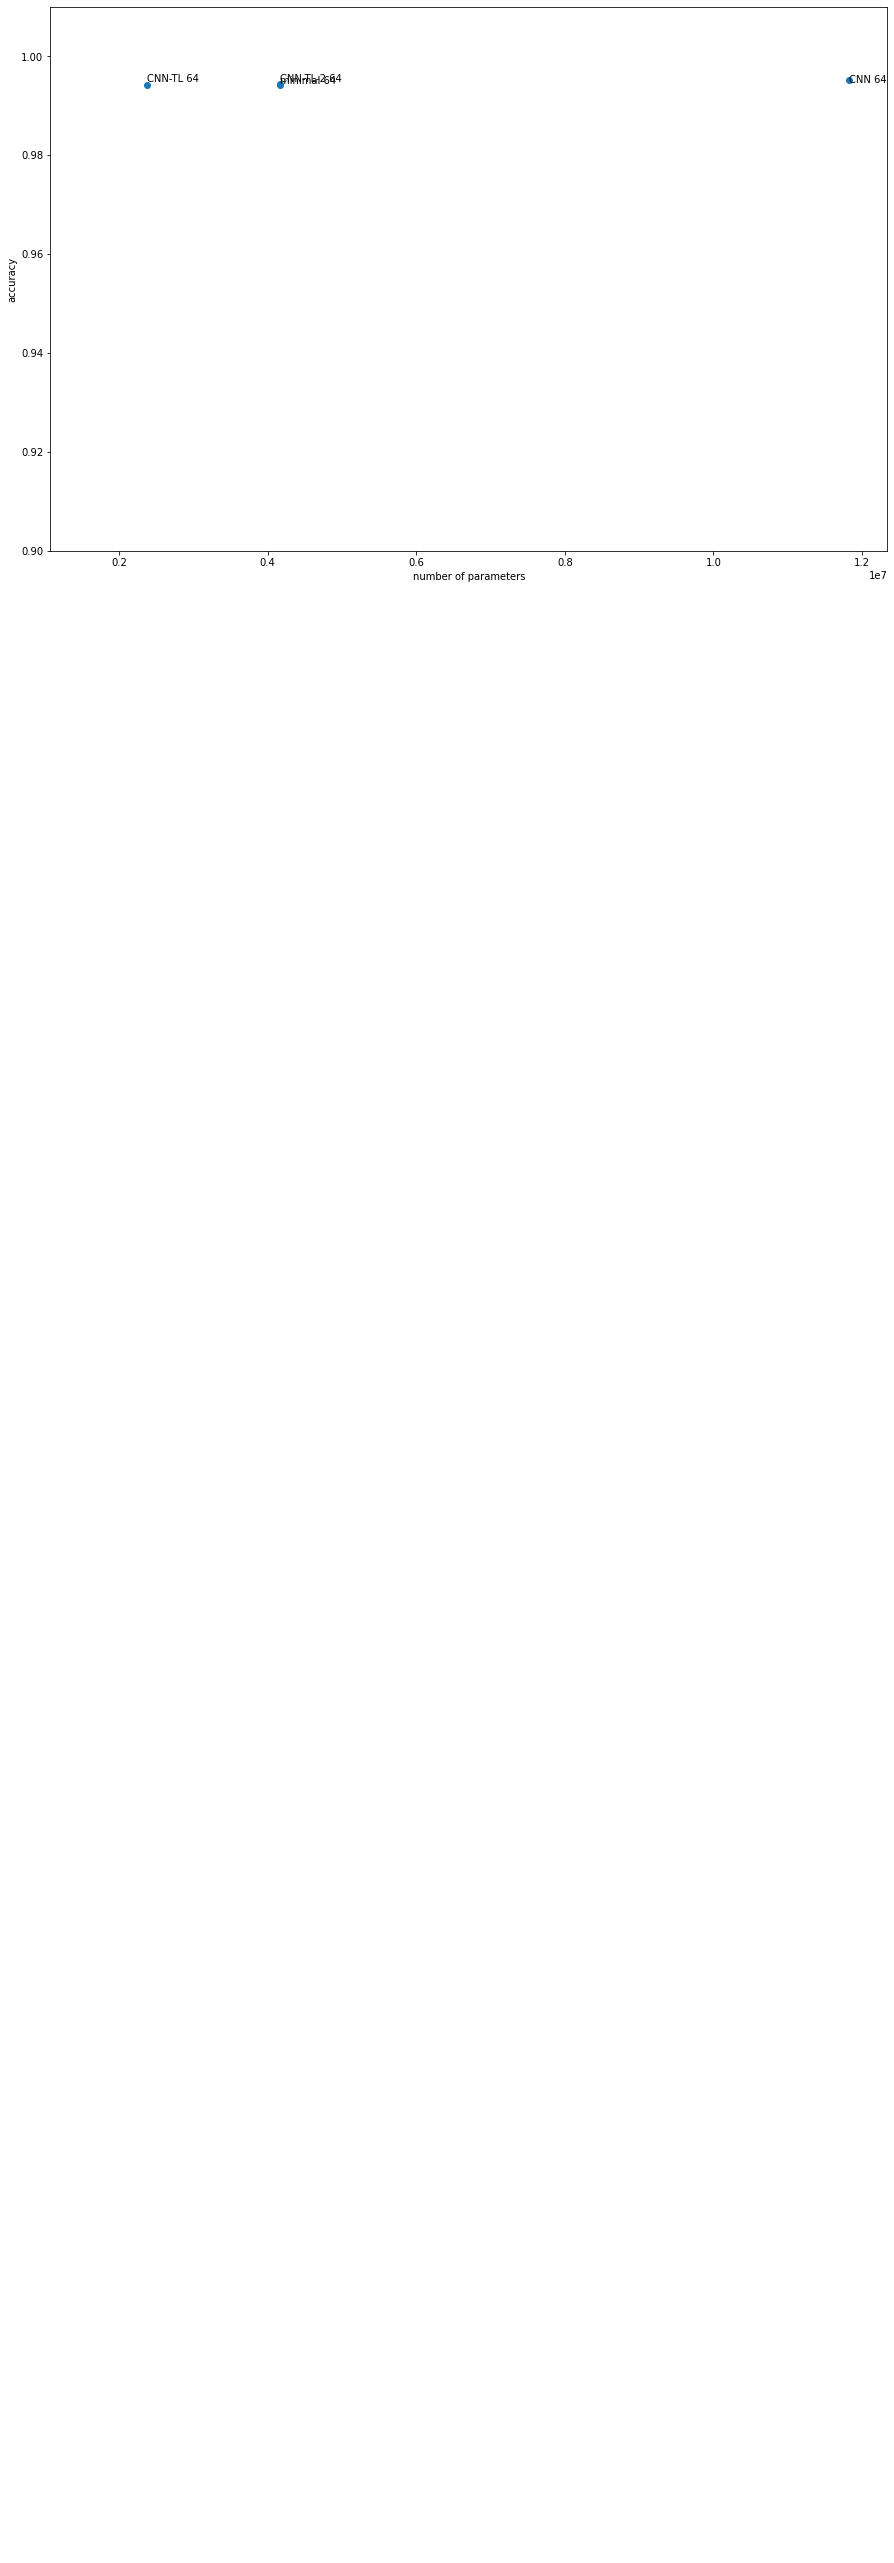

In [59]:
print_model_performance()

If you have not yet done so, please rerun your notebook with a different `size` parameter now. You should see both results in the table when you get back to the cell above.

Which model has the highest accuracy?

Answer: ___CNN 64 has the highest accuracy, with more ephos CNN with TL _64 might have better accuracy___

Which model has the fewest parameters (and an accuracy of at least 99.5%)?

Answer: ___CNN TL 64 ___

Which model would you choose? Why?

Answer: ___CNN with TL _64 with MobileNetV2/V3___

Discuss what else you observe in your results and what you have learned.

Answer: ___ANN performance is much worse compared to other CNN models, with tranfer learning the model need not be better than just CNN? Also size = 64 performes better than size = 32 ___